In [62]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from bubbly.bubbly import bubbleplot
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
import plotly.express as px
import plotly.io as pio
import nbformat
import textwrap

In [63]:
# import lda model and data
n_topics = 30
model_path = "data/lda/final_model/model.model"
lda_model = LdaModel.load(model_path)
data_path = "data/final.parquet"
df = pd.read_parquet(data_path)

In [64]:
def print_topics(model, n_topics=n_topics, k_words=10):
    '''
    print all n topics of the lda model 
    '''
    for idx, topic in model.show_topics(formatted=False, num_topics=n_topics):
        label = ", ".join([word for word, prob in topic[:k_words]])
        print(f"Topic {idx}: {label}")

In [65]:
print_topics(lda_model)

Topic 0: security, united, common, challenge, world, global, strong, future, political, defense
Topic 1: want, think, commissioner, say, know, good, colleague, today, come, talk
Topic 2: budget, fund, financial, euro, billion, million, payment, program, eur, resource
Topic 3: worker, transport, sector, fund, globalization, company, adjustment, industry, market, job
Topic 4: fishing, fishery, sea, water, fish, resource, sustainable, specie, management, vessel
Topic 5: financial, committee, agency, budget, discharge, court, institution, control, auditor, implementation
Topic 6: development, economic, strategy, growth, investment, region, area, sustainable, develop, objective
Topic 7: human, freedom, democracy, political, medium, journalist, government, respect, expression, violation
Topic 8: law, rule, government, democracy, treaty, poland, principle, respect, hungary, party
Topic 9: tax, company, fraud, money, evasion, multinational, financial, transparency, information, pay
Topic 10: w

In [ ]:
# topic labels
topic_labels = [
    "EU Security & Defense", # 0
    "Formalities & Procedure", # 1
    "EU Finances", # 2
    "Workers and Industry", # 3
    "Fisheries", # 4
    "Budgetary Control", # 5
    "Economic Development", # 6
    "Human Rights", # 7
    "Rule of Law", # 8
    "Taxation", # 9
    "Gender Equality", # 10
    "Terrorism & Political Violence", # 11
    "Food Safety", # 12
    "Economic Crisis", # 13
    "Climate & Energy", # 14
    "Trade Relations", # 15
    "International Conflicts", # 16
    "Education and Culture", # 17
    "Intra-European disputes", # 18
    "Migration and Asylum", # 19
    "Legislative Process", # 20
    "Russia–Ukraine", # 21
    "Social Policy & Labor", # 22
    "Data Protection", # 23
    "Agriculture", # 24
    "Election Law", # 25
    "Market Regulation", # 26
    "Health Emergencies", # 27
    "Sanctions & Condemnations", # 28
    "Children’s Rights" # 29
]

In [67]:
topic_list = []
for idx, topic in lda_model.show_topics(formatted=False, num_topics=n_topics):
    label = ", ".join([word for word, prob in topic[:3]])
    topic_list.append(label)

In [68]:
# # print speeches with highest probability for a given topic
# topic_id = 28
# prob_col = f"topic_{topic_id}"
# top_speeches = df.sort_values(by=prob_col, ascending=False).head(10)
# for i, row in top_speeches.iterrows():
#     print(f"Year: {row['year']} | Party block: {row['block']}")
#     print(f"Topic probability: {row[prob_col]:.4f}")
#     print(textwrap.fill(row["translatedText"], width=90))
#     print("\n"+"-"*80+"\n")


In [69]:
# select topic with highest probability for each speech
df['dominant_topic_id'] = df.loc[:, 'topic_0':'topic_29'].idxmax(axis=1).apply(lambda x: int(x.split('_')[1])).astype(int)
# give dominant topic its label
df['dominant_topic'] = df['dominant_topic_id'].apply(lambda x: topic_labels[x])

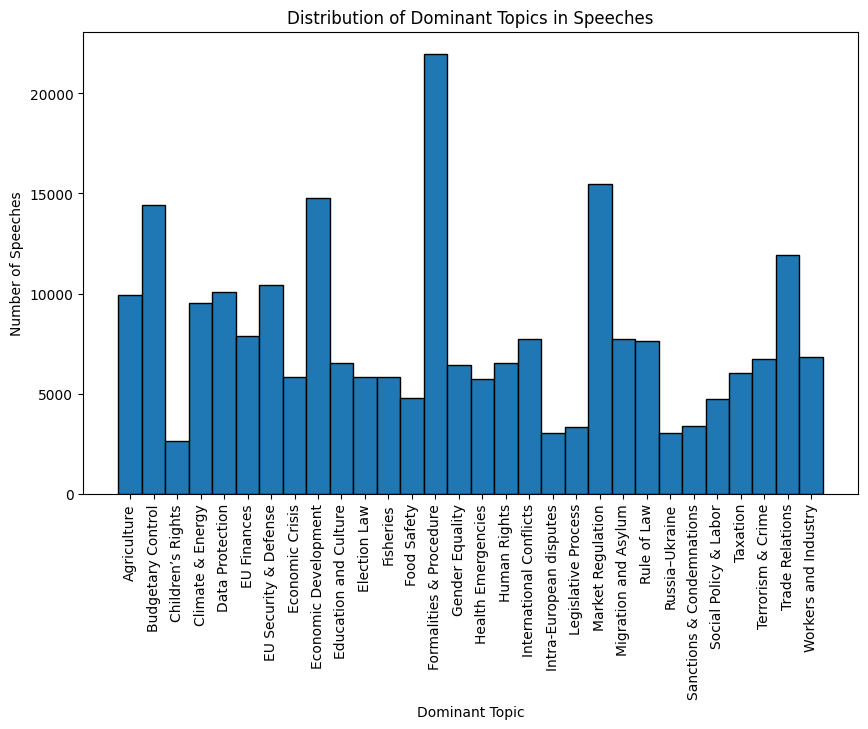

In [70]:
# histogram of dominant topics
plt.figure(figsize=(10,6))
plt.hist(df['dominant_topic'].sort_values(), bins=np.arange(-0.5, 30.5, 1), edgecolor='black')
plt.xticks(rotation=90)
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Speeches')
plt.title('Distribution of Dominant Topics in Speeches')
plt.show()

In [71]:
# rough left - right classification: should be replaced by chess data later - 1 left to 10 right
party_dict = {"PSE/S&D": 3,
              "PPE": 7,
                "ELDR/ALDE/Renew": 5,
                "Greens/EFA": 2,
                "ENF/ID": 9,
                "ECR": 8,
                "NGL/The Left": 1,
                "UEN" : 7,
                "EFD" : 8,
                "INDDEM/EDD": 7}
df['party_pos'] = df['party'].map(party_dict)

In [72]:
# delete all speeches with main topic 1 (formalities and brexit, weird to interpret)
df = df[df['dominant_topic_id'] != 1]

In [73]:
df_dominant = df.groupby(['dominant_topic', 'year']).agg({
    'text': 'count',
    'party_pos': 'mean'
}).reset_index().rename(columns={'text': 'count', 'party_pos': 'avg_party_pos'})

# Calculate total speeches per year
year_totals = df_dominant.groupby('year')['count'].sum().reset_index()
year_totals.columns = ['year', 'total_year']

# Merge and calculate ratio
df_dominant = df_dominant.merge(year_totals, on='year')
df_dominant['ratio'] = df_dominant['count'] / df_dominant['total_year']

# to df_dominant, add most probable speech for each topic and year
df_dominant['most_probable_speech'] = None
for i, row in df_dominant.iterrows():
    topic = row['dominant_topic']
    year = row['year']
    prob_col = f"topic_{topic_labels.index(topic)}"
    filtered_df = df[(df['year'] == year)]
    top_speech = filtered_df.sort_values(by=prob_col, ascending=False).iloc[0]
    speech_text = top_speech['translatedText'][:500] + "..." if len(top_speech['translatedText']) > 500 else top_speech['translatedText']
    speech_text = "<br>".join(textwrap.wrap(speech_text, width=80))
    df_dominant.at[i, 'most_probable_speech'] = speech_text

# add column with top 5 words for each topic
for i in range(n_topics):
    topic_terms = lda_model.show_topic(i, topn=5)
    top_words = ", ".join([word for word, prob in topic_terms])
    df_dominant.loc[df_dominant['dominant_topic'] == topic_labels[i], 'top_words'] = top_words

# sort in reverse alphabetical order
df_dominant = df_dominant.sort_values(by='dominant_topic', ascending=False)

In [74]:
del df

In [75]:
# sanity check: make sure that for each year, the sum of ratios equals 1
check = df_dominant.groupby('year')['ratio'].sum().reset_index()
assert all(np.isclose(check['ratio'], 1.0)), "Ratios do not sum to 1 for all years!"

# sanity check: make sure that for each year, each topic has only one entry
check2 = df_dominant.groupby(['year', 'dominant_topic']).size().reset_index(name='counts')
assert all(check2['counts'] == 1), "There are duplicate entries for some year-topic combinations!"

### Construct Stacked Area Chart

In [77]:
fig = px.area(df_dominant, 
              x='year', 
              y='ratio', 
              color='dominant_topic',
              hover_data={'dominant_topic': True, 'top_words': True, 'count': True, 'most_probable_speech': True},
              labels={'dominant_topic': 'Topic', 'year': 'Year', 'ratio': 'Proportion', 'count' : 'Absolute Number', 'top_words': 'Top 5 LDA Words', 'most_probable_speech': 'Most Probable Speech'},
              title='Topics discussed in the European Parliament from 2004 to 2024',
              subtitle='As identified by LDA topic modeling, expressed as proportions per year',
              range_y=[0,1]
              )

# Customize legend
fig.update_layout(
    legend=dict(
        orientation="v",  # "v" for vertical, "h" for horizontal
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=1.2,
        traceorder="reversed"
    )
)

fig.show()

In [157]:
# bubble plot: did not work as well, prob. stick with area plot
# topic_y_positions = {topic: i for i, topic in enumerate(sorted(df_dominant['dominant_topic'].unique()))}
# df_dominant['y_pos'] = df_dominant['dominant_topic'].map(topic_y_positions)

# fig = px.scatter(
#     df_dominant,
#     x="avg_party_pos",
#     y="y_pos",
#     size="ratio",
#     color="dominant_topic",
#     animation_frame="year",
#     hover_name="dominant_topic",
#     size_max=80
# )

# fig.update_yaxes(
#     tickvals=list(topic_y_positions.values()),
#     ticktext=list(topic_y_positions.keys()),
#     visible=True
# )
# fig.update_layout(
#     title="Topic prominence by year",
#     xaxis_title="Average political position",
#     yaxis_title="Topics",
#     showlegend=True
# )

# pio.renderers.default = "browser"
# fig.show()
